# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.stats as stats
import scipy.signal as signal
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


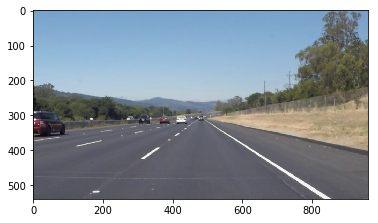

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

### Utility Functions

In [3]:
# Needed only for testing purpose
def one_to_three_channel(single_channel_image):
    return np.stack((single_channel_image,)*3, -1)

def slope_of_line(x1, y1, x2, y2):
    deg = math.degrees(math.atan2((y2 - y1), (x2 - x1)))
    return deg

def length_of_line(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

"""
In a normal scenario, the lanes are at certain angles
(35 +/- 10 degrees) in the image. The lines which do
satisfy these criteria should mostly be okay to remove.
"""
def include_line(slope):
    expected_angle = 45
    deviation = 18
    min = expected_angle - deviation
    max = expected_angle + deviation
    int_slope = abs(int(slope))
    
    if int_slope < min or int_slope > max:
        return False
    return True

"""
This function takes hough lines as input, and uses the information
to arrive at two straight lanes which correspond to the left and
the right lanes.
"""
def final_lines(lines, video_width, ymin, ymax):
    
    # Find the middle of screen (widthwise). We will use this to determine
    # whether a line/coordinate will be used to generate the left or
    # the right lane
    mid = video_width / 2
    
    #Initializing numpy arrays to store coordinates from hough lines
    left_x, left_y, right_x, right_y = np.array([]), np.array([]), np.array([]), np.array([])
    
    # Initializing the end coordinates of the left lane:
    # (left_x1, left_y1) and (left_x2, left_y2)
    left_x1, left_y1, left_x2, left_y2 = 0., 0., 0., 0.
    
    # Initializing the end coordinates of the right lane:
    # (right_x1, right_y1) and (right_x2, right_y2)
    right_x1, right_y1, right_x2, right_y2 = 0., 0., 0., 0.
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            
            # Calculating slope, length of line etc to determine whether or
            # not to include the hough line to come to the final result (two lines)
            slope = slope_of_line(x1, y1, x2, y2)
            length = length_of_line(x1, y1, x2, y2)
            
            # Considering only those lines which meets the criteria. Eg.
            # if the line is to the left of the image, the slope should be
            # negative and between certain degrees. Same for the hough lines on the right.
            
            # If they meet the criteria, the end coordinates of the lines are
            # stored in the respective numpy arrays.
            if ((x1 < mid and x2 < mid and slope < 0 and include_line(slope) == True) or (x1 > mid and x2 > mid and slope > 0 and include_line(slope) == True)):
                if x1 < mid:
                    left_x, left_y = np.append(left_x, [x1]), np.append(left_y, [y1])
                else:
                    right_x, right_y = np.append(right_x, [x1]), np.append(right_y, [y1])

                if x2 < mid:
                    left_x, left_y = np.append(left_x, [x2]), np.append(left_y, [y2])
                else:
                    right_x, right_y = np.append(right_x, [x2]), np.append(right_y, [y2])
    
    # If the arrays are empty, they cannot be regressed. Otherwise, we perform
    # curve-fitting on the array using linear regression function.
    
    # Once we have slopes(slope_left, slope_right) and y-intercepts(intercept_left, intercept_right)
    # of both the lines (left and right), we find the x and y coordinates of the lines (lanes)
    # between y=ymin and y=ymax using the formula y=mx+b (or x=(y-b)/m)
    # of both the lines at y=ymin and y=ymax  
    
    if left_x.size>0 and left_y.size >0:
        slope_left, intercept_left, r_value1, p_value1, std_err1 = stats.linregress(left_x, left_y)
        left_x1, left_y1, left_x2, left_y2 = (ymax - intercept_left) / slope_left, ymax, (ymin - intercept_left) / slope_left, ymin

    if right_x.size>0 and right_y.size >0:
        slope_right, intercept_right, r_value2, p_value2, std_err2 = stats.linregress(right_x, right_y)
        right_x1, right_y1, right_x2, right_y2 = (ymin - intercept_right) / slope_right, ymin, (ymax - intercept_right) / slope_right, ymax

    # Returning the end-coordinates of the lanes as an array.
    return np.array([left_x1, left_y1, left_x2, left_y2, right_x1, right_y1, right_x2, right_y2]).astype(int)
    

### Helpers for Image Transformation

In [19]:

"""
This function creates an applies a mask on the image to only
return the white and yellow regions of the image (which usually
corresponds to lane color)
"""
def filter_white_and_yellow(image):
    # Building a white mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    
    # Building a yellow mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    
    # Merging white and yellow mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    
    # Applying mask on the given image and returning the result.
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

"""
This function applies the Grayscale transformation on the
provided image to return a one-colr grayscale image.
NOTE: to see the returned image as grayscale
(assuming your grayscaled image is called 'gray')
you should call plt.imshow(gray, cmap='gray')
"""
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

"""
Applies a Gaussian Noise kernel
"""
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

"""
Applies an image mask to extractthe region of the image defined by the 
polygon formed from `vertices`. The rest of the image is set to black.
`vertices` should be a numpy array of integer points.
"""
def region_of_interest(img, vertices):
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

"""
Applies the Canny transformation on the provided image
"""
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

"""
NOTE: this is the function you might want to use as a starting point once you want to 
average/extrapolate the line segments you detect to map out the full
extent of the lane (going from the result shown in raw-lines-example.mp4
to that shown in P1_example.mp4).  

Think about things like separating line segments by their 
slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
line vs. the right line.  Then, you can average the position of each of 
the lines and extrapolate to the top and bottom of the lane.

This function draws `lines` with `color` and `thickness`.    
Lines are drawn on the image inplace (mutates the image).
If you want to make the lines semi-transparent, think about combining
this function with the weighted_img() function.

"""
def draw_lines(img, lines, video_width, ymin, ymax, color, thickness):    
    final_lines_result = final_lines(lines, video_width, ymin, ymax)
    if final_lines_result is not None:
        [left_x1, left_y1, left_x2, left_y2, right_x1, right_y1, right_x2, right_y2] = final_lines_result
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)

"""
This function takes an image (output of Canny transformation) and
returns an (empty) image containing two straight lines derived from
Hough lines.
"""
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, video_width, ymin, ymax, color, thickness):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, video_width, ymin, ymax, color, thickness)
    return line_img

"""
This function takes the original image (initial_img) and the empty image with
Hough lines, and returns a final image with the lane lines overlayed on top of
the original image.

`img` is the output of the hough_lines(), An image with lines drawn on it.
Should be a blank image (all black) with lines drawn on it.

`initial_img` should be the image before any processing.

The result image is computed as follows:

initial_img * α + img * β + γ
NOTE: initial_img and img must be the same shape!
"""
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)


## Build a Lane Finding Pipeline



In [23]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def add_image(obj, key, name, image, cmap=None):
    obj[key] = {
        'name': name,
        'image': image,
        'cmap': cmap
    }
    return obj

def run_image_processing(image, color=[255, 0, 0], thickness=5, exec_white_yellow_mask=False, exec_otsu=False):
    
    result = {}
    result = add_image(result, 'original', 'Original Image', image)
    rgb_image = image
    
    if exec_white_yellow_mask == True:
        # Detect the white and yellow colors (corresponding to
        # lane marker colors) in the picture
        rgb_image = filter_white_and_yellow(image)
        result = add_image(result, 'white_yellow', 'Filtered yellow and white', rgb_image)
    
    # Convert image to grayscale
    grayscale_image = grayscale(rgb_image)
    result = add_image(result, 'grayscale', 'Grayscale image', grayscale_image, 'gray')

    # Applying Gaussian blur
    kernel_size = 3
    blur_image = gaussian_blur(grayscale_image, kernel_size)
    result = add_image(result, 'blur', 'After Gaussian blur transformation', blur_image, 'gray')
    image_for_edge_detection = blur_image
    
    if exec_otsu == True:
        # Applying otzu thresholding
        # Reference: https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
        ret, threshold = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        result = add_image(result, 'otsu', 'After Otsu thresholding', threshold, 'gray')
        image_for_edge_detection = threshold

    # Canny Edge Detection
    low_threshold = 50
    high_threshold = 150
    canny_image = canny(image_for_edge_detection, low_threshold, high_threshold)
    result = add_image(result, 'canny', 'After drawing Canny edges', canny_image, 'gray')

    # Restricting to region of interest
    imshape = image.shape
    video_width = imshape[1]
    video_height = imshape[0]
    ymin = video_height * 0.60
    ymax = video_height

    top_left = (video_width * 0.48, ymin)
    top_right = (video_width * 0.52, ymin)
    bottom_left = (0, ymax)
    bottom_right = (video_width, ymax)
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    masked_image = region_of_interest(canny_image, vertices)
    result = add_image(result, 'region_of_interest', 'Restricting to certain area of interest', masked_image, 'gray')

    # Hough Transform
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    hough_transformed_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap, video_width, ymin, ymax, color, thickness)
    result = add_image(result, 'hough', 'Hough transformed image', hough_transformed_image)

    # Detected lane markers overridden on top of original image
    # final_image = weighted_img(hough_transformed_image, image)
    final_image = weighted_img(hough_transformed_image, image)
    result = add_image(result, 'overlay', 'Original image with lane lines overlay', final_image)
    
    # Added only for test
    # three_channel_masked_image = np.stack((masked_image,)*3, -1)
    # final_image = weighted_img(hough_transformed_image, three_channel_masked_image) 
    
    # Return processed image
    return result


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

### To demonstrate image processing pipeline (with **white/yellow filter** and **otsu thresholding**)

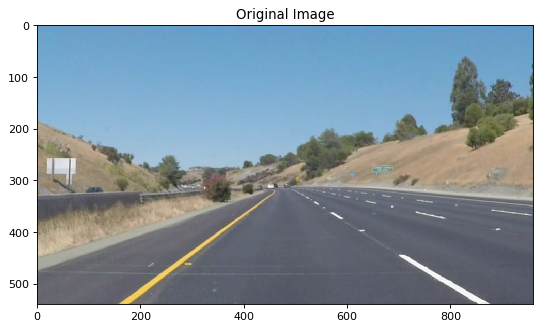

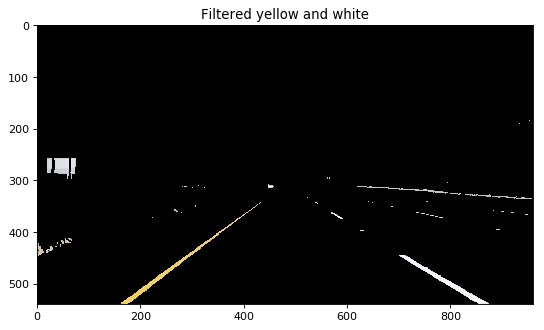

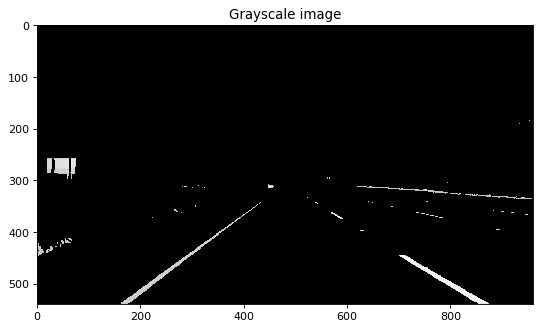

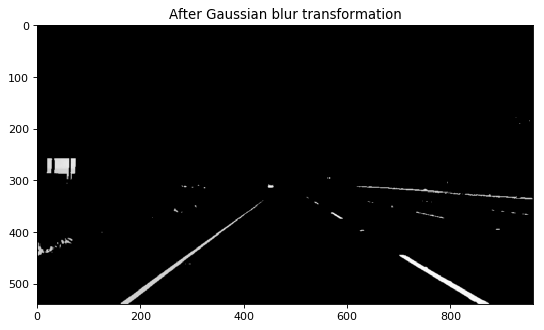

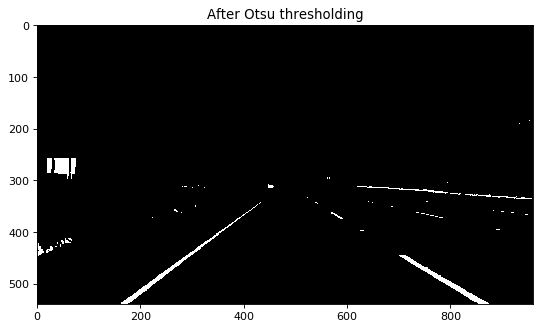

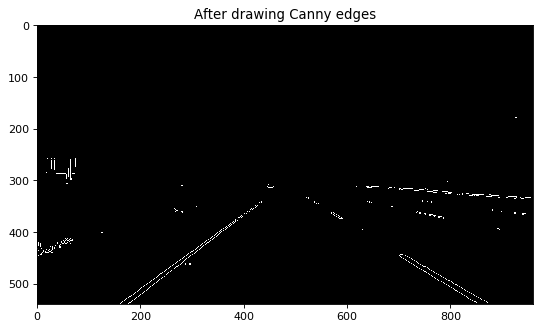

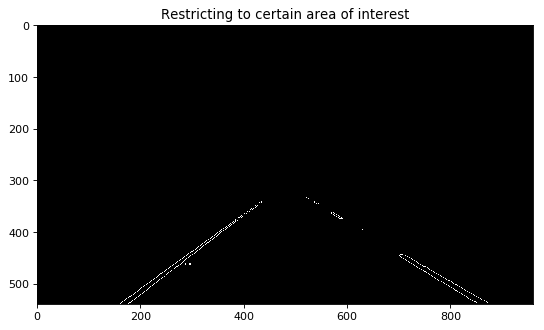

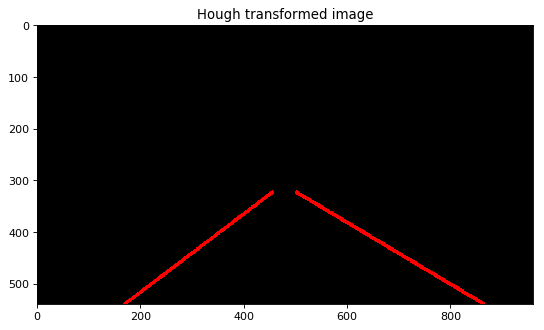

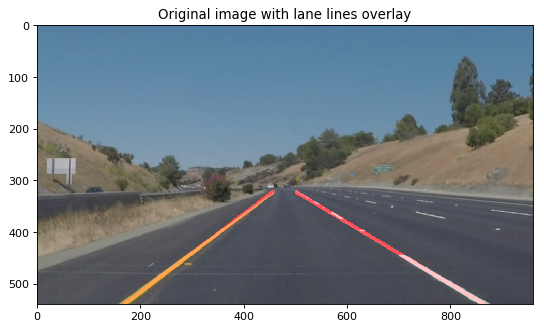

In [24]:
import os
input_image = mpimg.imread('test_images/solidYellowCurve2.jpg')
result = run_image_processing(input_image, exec_white_yellow_mask=True, exec_otsu=True)

for key in result:
    entry = result[key]
    name = entry['name']
    img = entry['image']
    cmap = entry['cmap']

    plt.figure(figsize=(8, 6), dpi=80)
    plt.title(name)
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)

### Noisy image; No white-yellow filter

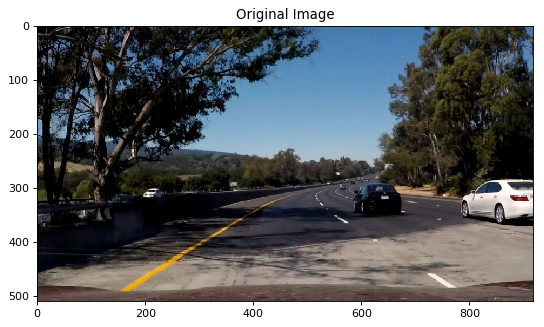

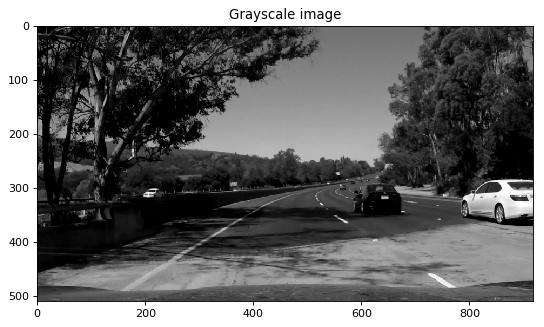

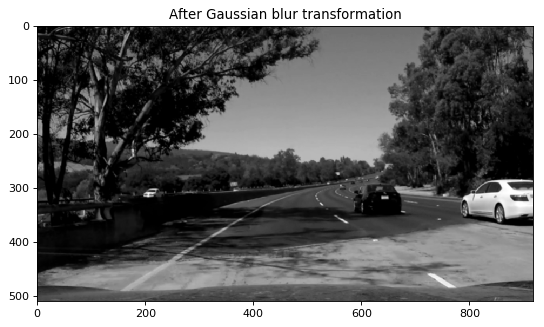

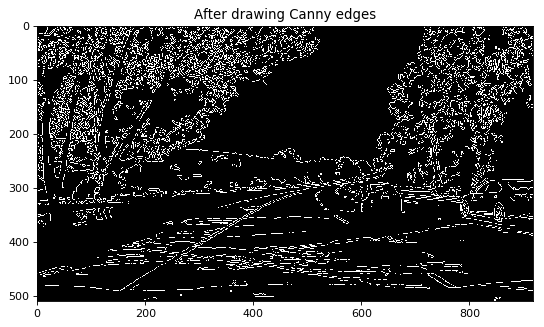

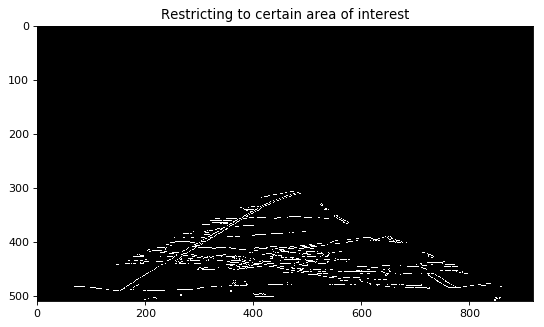

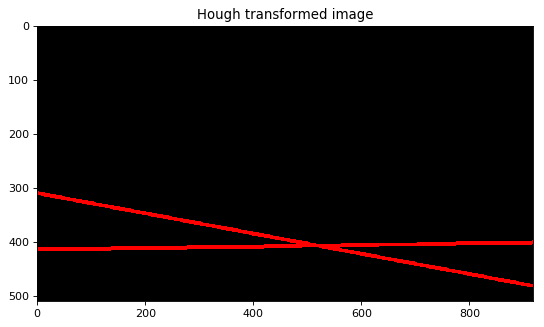

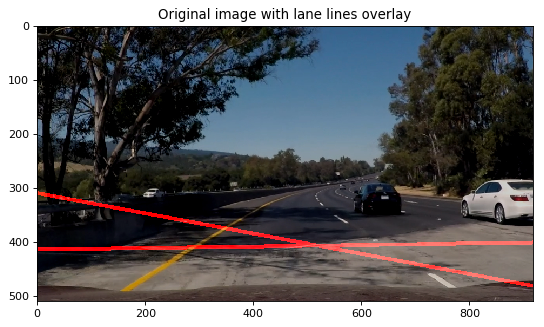

In [26]:
import os
input_image = mpimg.imread('writeup-resources/noisy.jpg')
result = run_image_processing(input_image, exec_white_yellow_mask=False)

for key in result:
    entry = result[key]
    name = entry['name']
    img = entry['image']
    cmap = entry['cmap']

    plt.figure(figsize=(8, 6), dpi=80)
    plt.title(name)
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)

## Illustration of Otsu thresholding

### Grayscale only

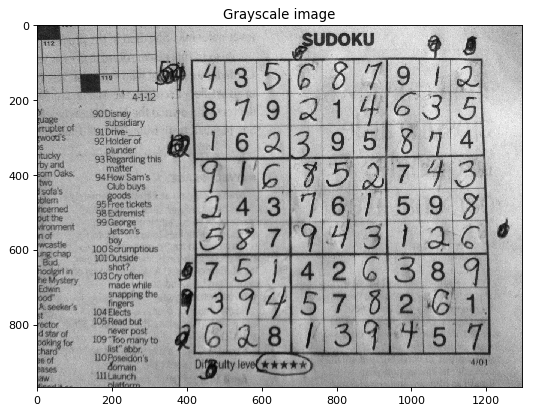

In [39]:
import os
rgb_image = mpimg.imread('writeup-resources/sudoku.jpg')

# Grayscale transformation and display
grayscale_image = grayscale(rgb_image)
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Grayscale image')
plt.imshow(grayscale_image, cmap='gray')

### Grayscale + Otsu Thresholding

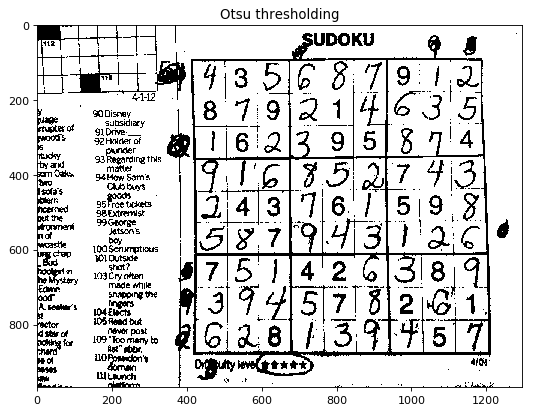

In [40]:
## Illustration of Otsu thresholding

import os
rgb_image = mpimg.imread('writeup-resources/sudoku.jpg')

# Grayscale transformation and display
grayscale_image = grayscale(rgb_image)

# Otsu transformation and render
ret, otsu_transformed_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Otsu thresholding')
plt.imshow(otsu_transformed_image, cmap='gray')

### Otsu transformation in the context of lane detection

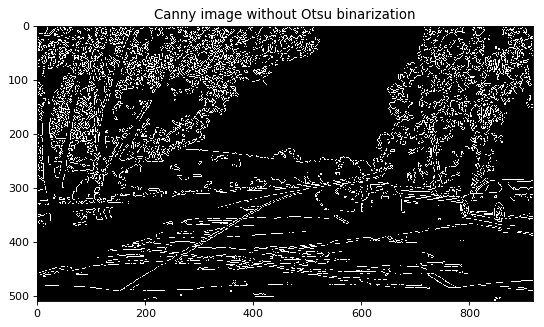

In [50]:
import os
input_image = mpimg.imread('writeup-resources/noisy.jpg')
result = run_image_processing(input_image, exec_white_yellow_mask=False, exec_otsu=False)

canny_image = result['canny']['image']
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Canny image without Otsu binarization')
plt.imshow(canny_image, cmap='gray')

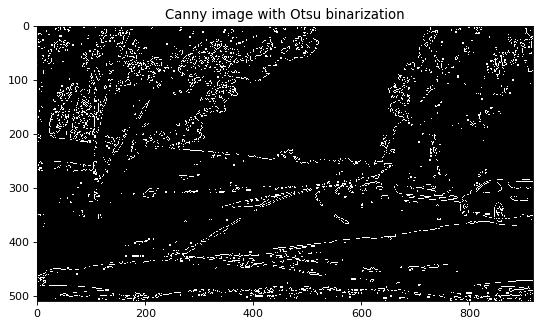

In [52]:
import os
input_image = mpimg.imread('writeup-resources/noisy.jpg')
result = run_image_processing(input_image, exec_white_yellow_mask=False, exec_otsu=True)

canny_image = result['canny']['image']
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Canny image with Otsu binarization')
plt.imshow(canny_image, cmap='gray')